In [1]:
import tensorflow as tf
import tensorflow.contrib.learn.python.learn as learn
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
%matplotlib inline

# Define functions

In [27]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    # Replace outlier reading 138 (far far too big!)
    classData[138] = classData[137]
    coilData[138] = coilData[137]
    
    return classData, coilData

def processCoilData(coilData, expand):
    """
    The coil data is an array of shape [400,15,2000] (1 second @ 1GHz for a set of 15 SQUIDs for 
    400 total runs on a group of 60 heathy and 60 unhealthy patients). 
    
    This function first reduces the coil data to every 40th point, without a major loss of information. 
    If expand == True, then it then iterates over the dataset, taking every 40th point from a starting 
    position of i=1,2,3,...,40. 
    In this way we can artificially expand each individual set of coilData into 40 similar sets.
    
    Returns an array of shape [40*400,750] if expand == True, or shape [400, 750] if expand == False.
    """
    if expand == True:
        # Initialise expanded data array.
        coilDataCut = np.zeros((16000, 750))

        for j in np.arange(0,40,1):
            for i in np.arange(0,400,1):
                coilDataCut[i+(j*400)] = np.hstack(coilData[i])[j::40]
        
        return coilDataCut
    if expand == False:
        coilDataCut = np.zeros((400,750))
        
        for i in np.arange(0,400,1):
            coilDataCut[i] = np.hstack(coilData[i])[0::40]
            
        return coilDataCut

def processClassData(classData, expand):
    """
    Process classData to complement that of the data processed by processCoilData.
    
    Returns a one-hot array of shape [40*400,2] if expand == True, and an array of shape
    [400,2] if expand == False.
    """
    # Convert label data to one-hot array
    classDataOH = np.zeros((400,2))
    classDataOH[np.arange(400), classData.astype(np.int)] = 1
    
    if expand == True:
        classDataOH = np.tile(classDataOH, (40,1))
    
    return classDataOH

In [28]:
classData, coilData = importPickle("./inData/6060DataFrame.pkl")
expand = False
coilData = processCoilData(coilData, expand)
#coilDataRS = np.reshape(coilData, (-1,15,50))
classData = processClassData(classData, expand)

(400, 750)
(400, 2)


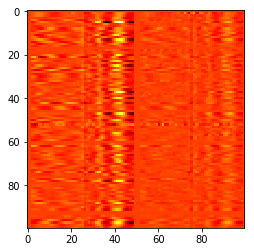

In [40]:
print(np.shape(coilData))
print(np.shape(classData))

plt.imshow(coilData[0:100,0:100], cmap='hot', interpolation='nearest')
plt.savefig("./outData/blahblah.png")

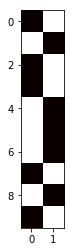

In [41]:
plt.imshow(classData[0:10], cmap='hot', interpolation='nearest')

(400, 750)


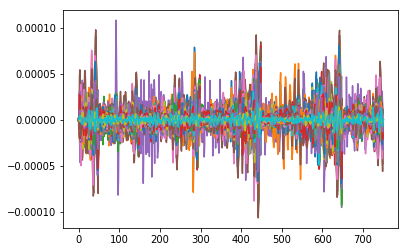

In [42]:
for i in np.arange(0,400,1):
    plt.plot(coilData[i])
print(coilData.shape)

In [43]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [44]:
sess = tf.InteractiveSession()

In [45]:
x = tf.placeholder(tf.float32, shape=[None, 750])
x_image = tf.reshape(x, [-1,15,50,1])
y_ = tf.placeholder(tf.float32, shape=[None, 2])
    
# FIRST LAYER
W_conv1 = weight_variable([5, 5, 1, 128])
b_conv1 = bias_variable([128])
    
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
    
# SECOND LAYER
W_conv2 = weight_variable([5, 5, 128, 256])
b_conv2 = bias_variable([256])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
    
# FULLY CONNECTED LAYER
W_fc1 = weight_variable([13 * 4 * 256, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 13*4*256])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
# DROPOUT
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
# SOFTMAX READOUT LAYER
W_fc2 = weight_variable([1024, 2])
b_fc2 = bias_variable([2])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
    
########################
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
    
train_step = tf.train.AdamOptimizer(1e-6).minimize(cross_entropy)
    
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
    
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
sess.run(tf.global_variables_initializer())

In [47]:
batchCoil = np.split(coilData, 10)
batchClass = np.split(classData, 10)

for i in np.arange(0,40,1):
    
    if i%1 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batchCoil[i], y_: batchClass[i], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    x_val = batchCoil[i]
    y_val = batchClass[i]
    train_step.run(feed_dict={x: x_val, y_: y_val, keep_prob: 0.5})

step 0, training accuracy 0.575
step 1, training accuracy 0.5
step 2, training accuracy 0.4
step 3, training accuracy 0.55
step 4, training accuracy 0.4
step 5, training accuracy 0.5
step 6, training accuracy 0.5
step 7, training accuracy 0.575
step 8, training accuracy 0.675
step 9, training accuracy 0.45


IndexError: list index out of range

In [49]:
train_accuracy = accuracy.eval(feed_dict={
            x:coilData[1:400], y_: classData[1:400], keep_prob: 1.0})
print("training accuracy %g"%(train_accuracy))

training accuracy 0.513784
